In [6]:
import numpy as np
import pandas as pd
import pickle
import os

from collections import namedtuple

import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
ModelParams = None

model_names = os.listdir('./output/models/')

models = {}
for model in model_names:
    model_dict = pickle.load(open('./output/models/{}'.format(model), 'rb'))
    if ModelParams is None:
        ModelParams = namedtuple('ModelParams', model_dict.keys())
    models[model] = ModelParams(**model_dict)

def split(model_name):
    gene, prior_variance, K, run = model_name.split('_')[:-1]
    
    gene = gene[4:]
    prior_variance = float(prior_variance[6:])
    K = int(K[1:])
    run = int(run)
    return {'gene': gene, 'prior_variance': prior_variance, 'K': K, 'run': run}

def get_key(row):
    return 'gene{}_sigma2{}_K{}_{}_model'.format(*list(row))

def get_zscores(gene):
    pass

In [102]:
def get_inputs(zscore_path, ld_path, gene):
    X = pd.read_csv(ld_path + gene, index_col=0)
    zscores = pd.read_csv(zscore_path + gene + '.zscore_matrix.txt', '\t', index_col=0)

    nan_snps = np.all(np.isnan(X.values), axis=1)
    X = X.iloc[~nan_snps].iloc[:, ~nan_snps]

    active_snps = np.isin(X.index, zscores.index)
    X = X.iloc[active_snps].iloc[:, active_snps]

    active_snps = np.isin(zscores.index, X.index)
    Y = zscores.iloc[active_snps]
    Y = Y.iloc[:, ~np.any(np.isnan(Y.values), 0)]
    

    tissues = Y.columns.values
    snp_ids = Y.index.values
    pos = np.array([int(snp_id.split('_')[1]) for snp_id in snp_ids])

    Y = Y.T.values
    X = X.values
    X = (X + np.eye(X.shape[0])*1e-6) / (1+1e-6)
    
    return X, Y, tissues, snp_ids

In [103]:
zscore_path = '../data/zscore_genes_for_Karl/'
ld_path = '../marios_correlation_matrices/'
X, Y, tissues, snp_ids = get_inputs(zscore_path, ld_path, gene)

In [104]:
keys = list(models.keys())

In [105]:
overview = pd.DataFrame([split(model_name) for model_name in model_names])
genes = np.unique(overview.gene)

In [106]:
overview.loc[:, 'idx'] = np.arange(overview.shape[0])

In [107]:
zscore_path = '../data/zscore_genes_for_Karl/'
ld_path = '../marios_correlation_matrices/'
X, Y, tissues, snp_ids = get_inputs(zscore_path, ld_path, genes[0])

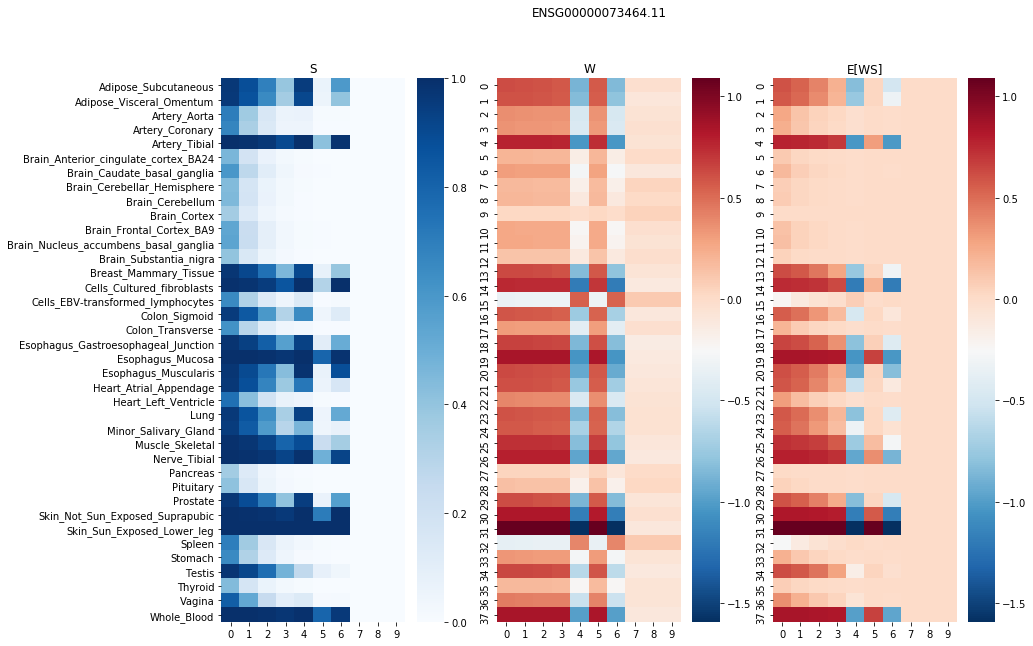

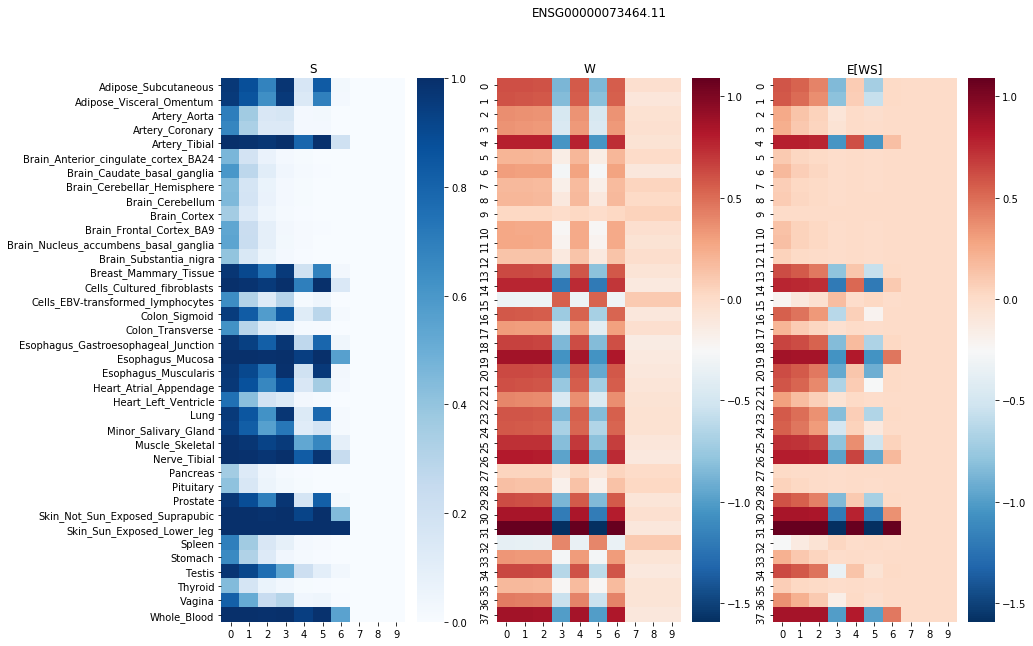

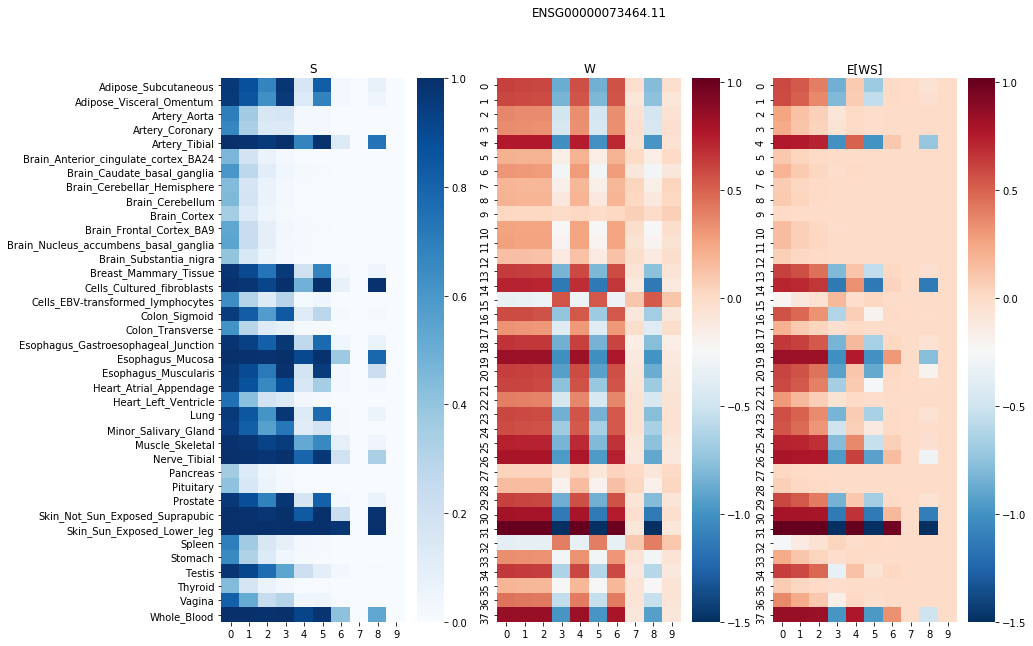

In [93]:
gene = genes[0]
for run in range(3):
    key = get_key((gene, 0.1, 10, run))
    m = models[key]
    fig, ax = plt.subplots(1, 3, figsize=(14, 10))
    sns.heatmap(np.exp(m.active), cmap='Blues', ax=ax[0], yticklabels=m.tissues)
    sns.heatmap(m.weights, cmap='RdBu_r', ax=ax[1])
    sns.heatmap(np.exp(m.active) * m.weights, cmap='RdBu_r', ax=ax[2])
    ax[0].set_title('S')
    ax[1].set_title('W')
    ax[2].set_title('E[WS]')
    plt.suptitle(gene)
    plt.show()

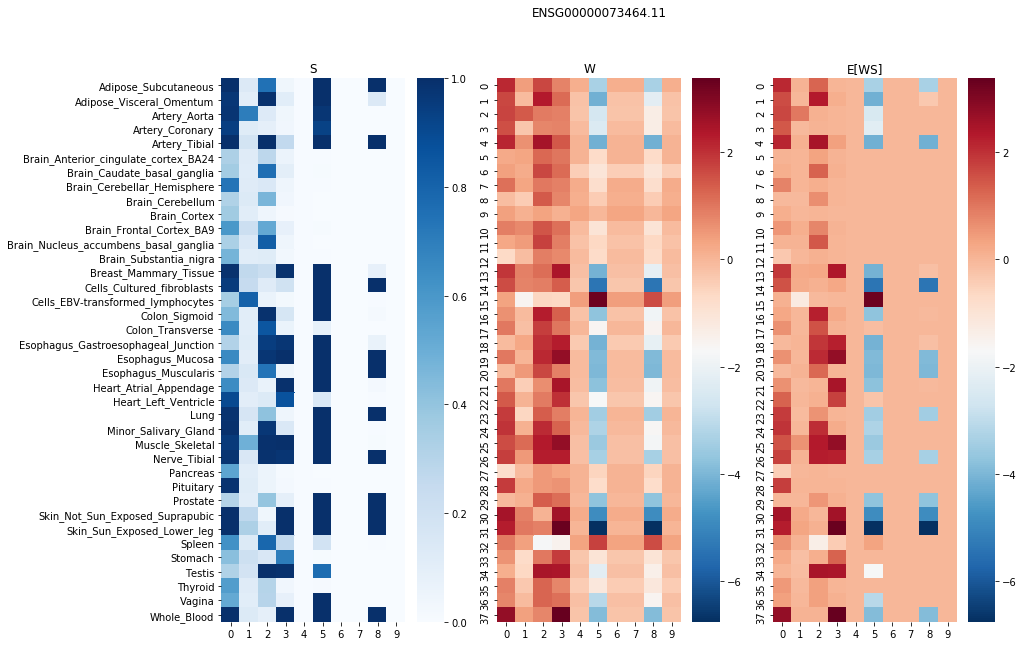

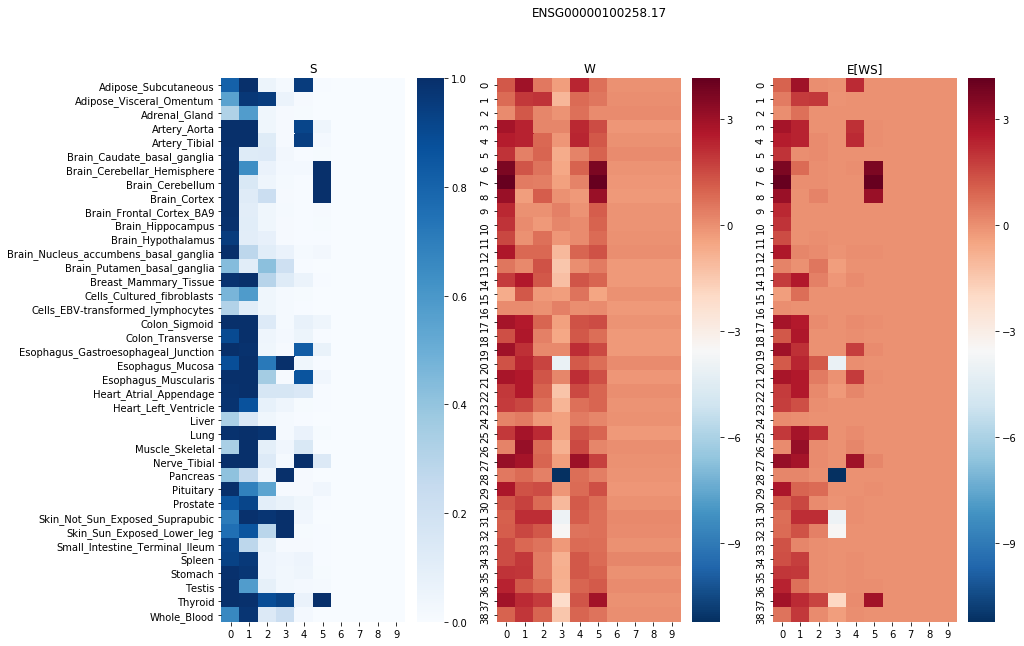

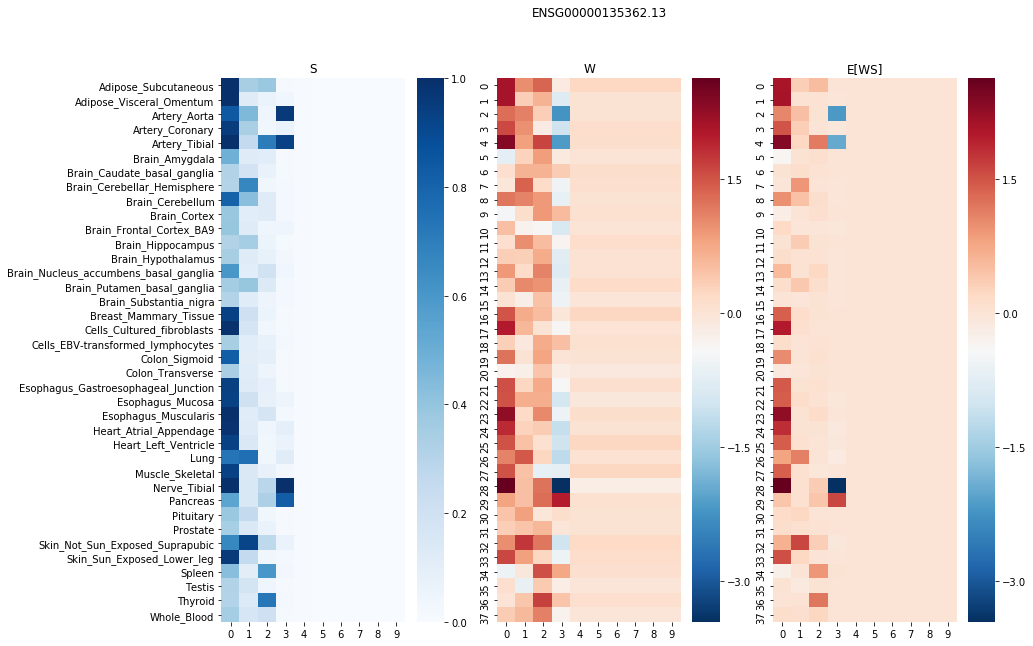

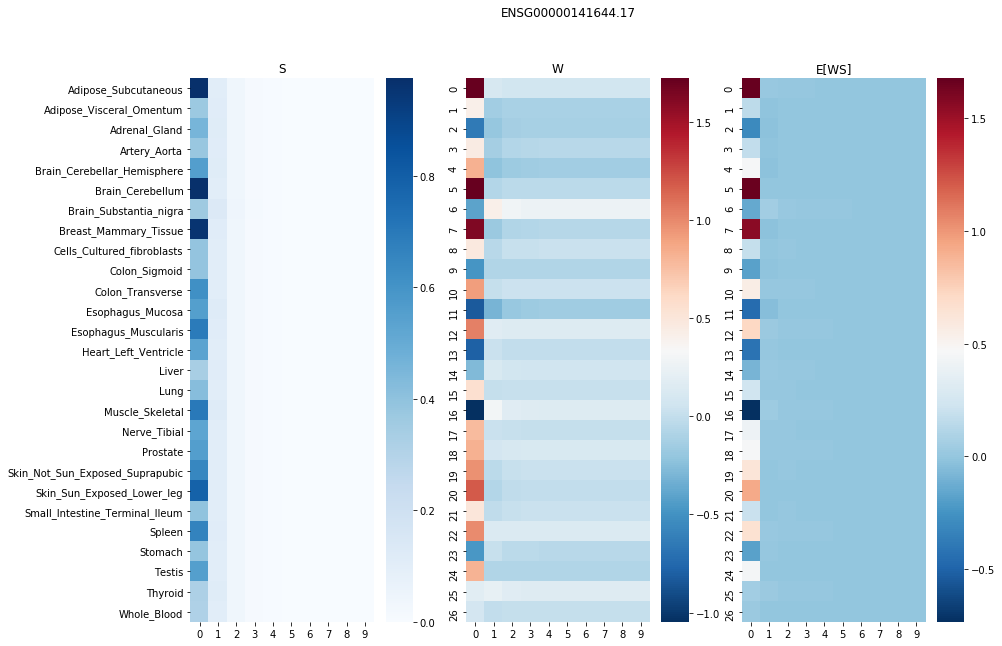

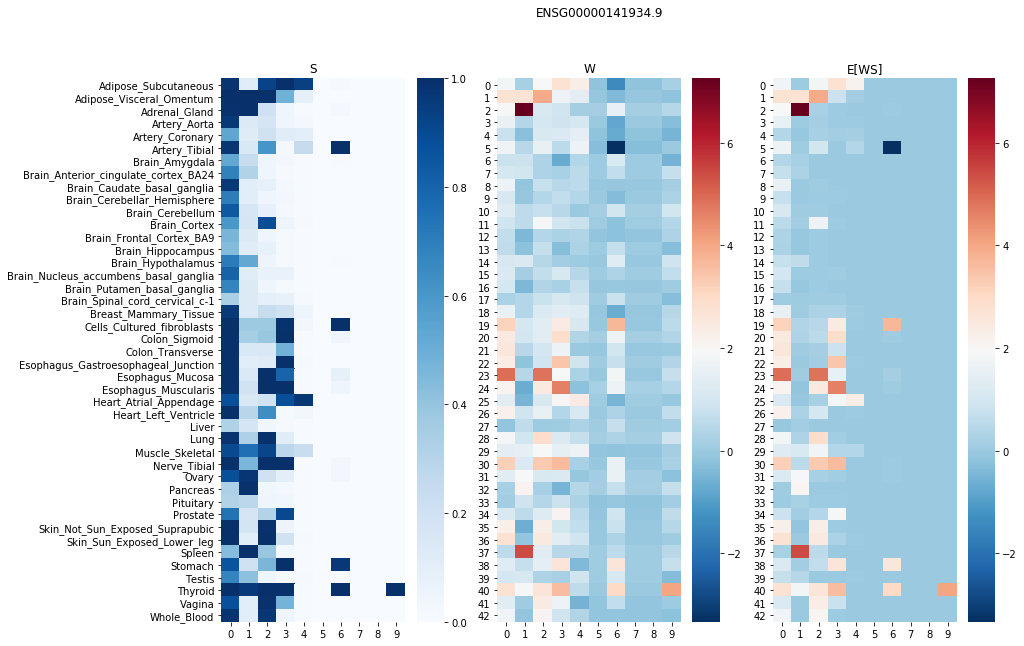

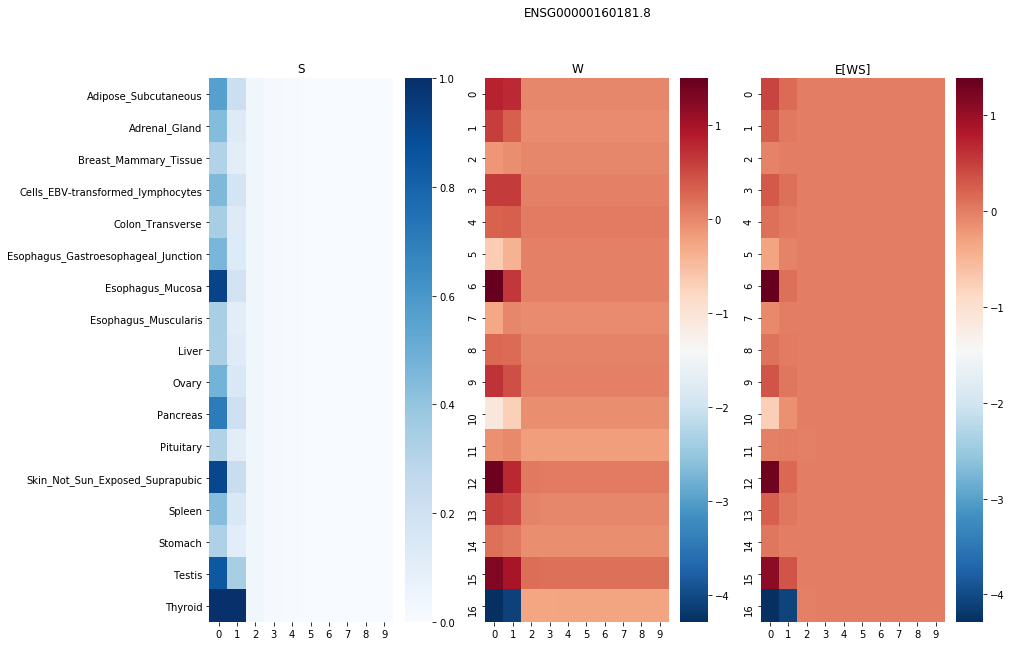

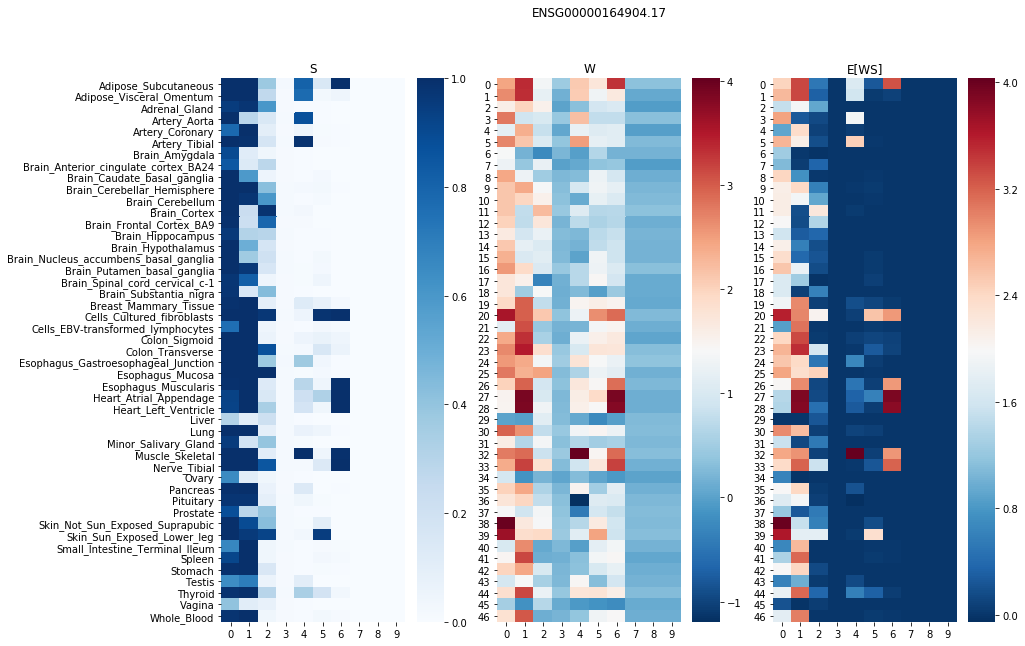

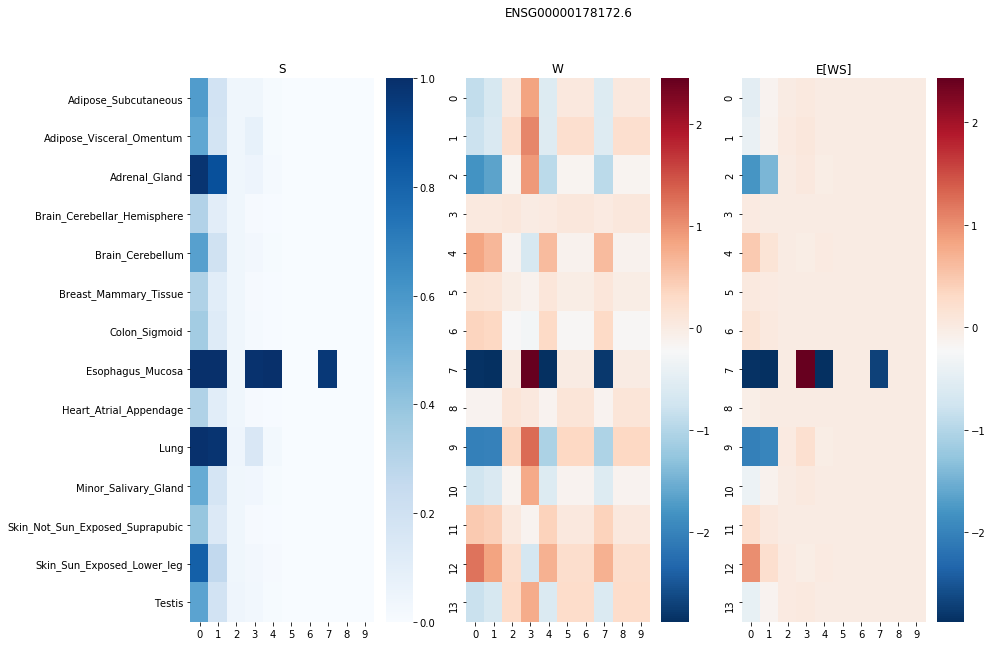

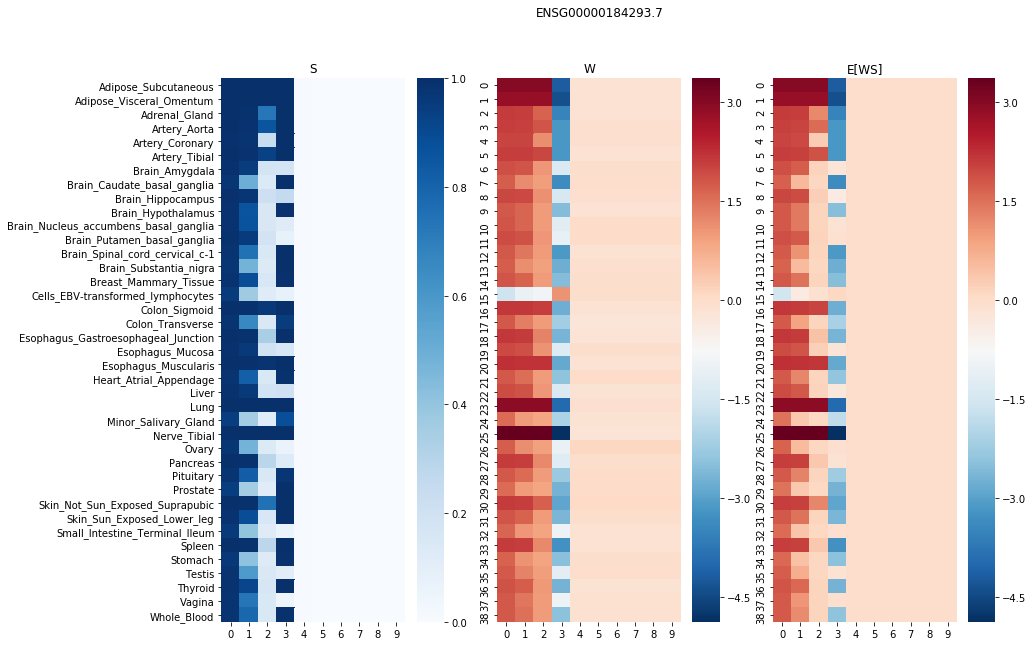

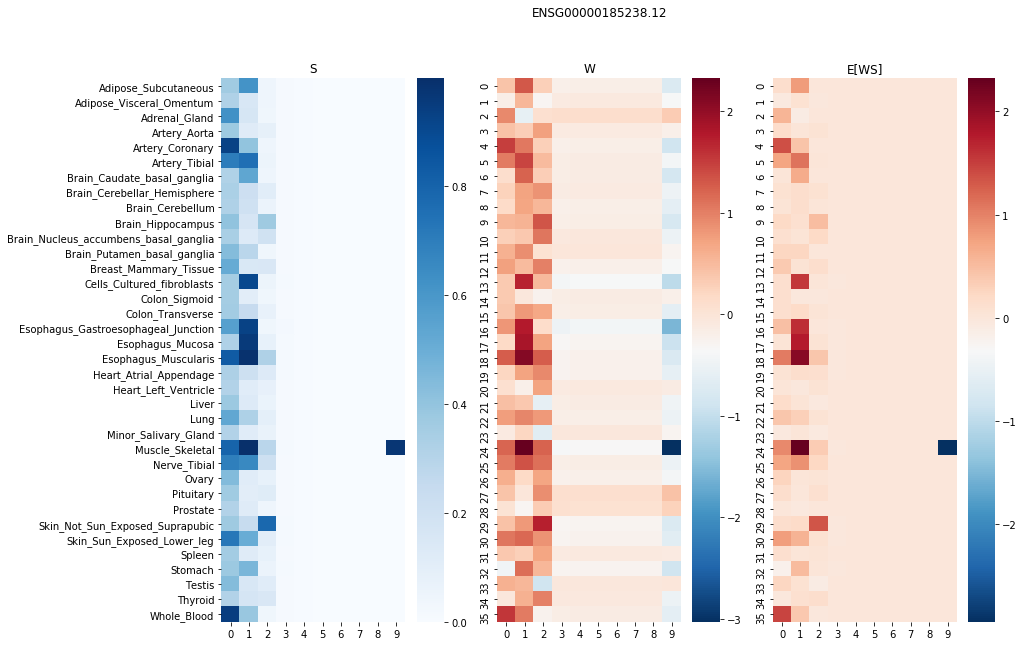

In [87]:
for gene in genes:
    key = get_key((gene, 1.0, 10, 0))
    m = models[key]
    fig, ax = plt.subplots(1, 3, figsize=(14, 10))
    sns.heatmap(np.exp(m.active), cmap='Blues', ax=ax[0], yticklabels=m.tissues)
    sns.heatmap(m.weights, cmap='RdBu_r', ax=ax[1])
    sns.heatmap(np.exp(m.active) * m.weights, cmap='RdBu_r', ax=ax[2])
    ax[0].set_title('S')
    ax[1].set_title('W')
    ax[2].set_title('E[WS]')
    plt.suptitle(gene)
    plt.show()

In [116]:
key = get_key((genes[0], 1.0, 10, 0))
m = models[key]

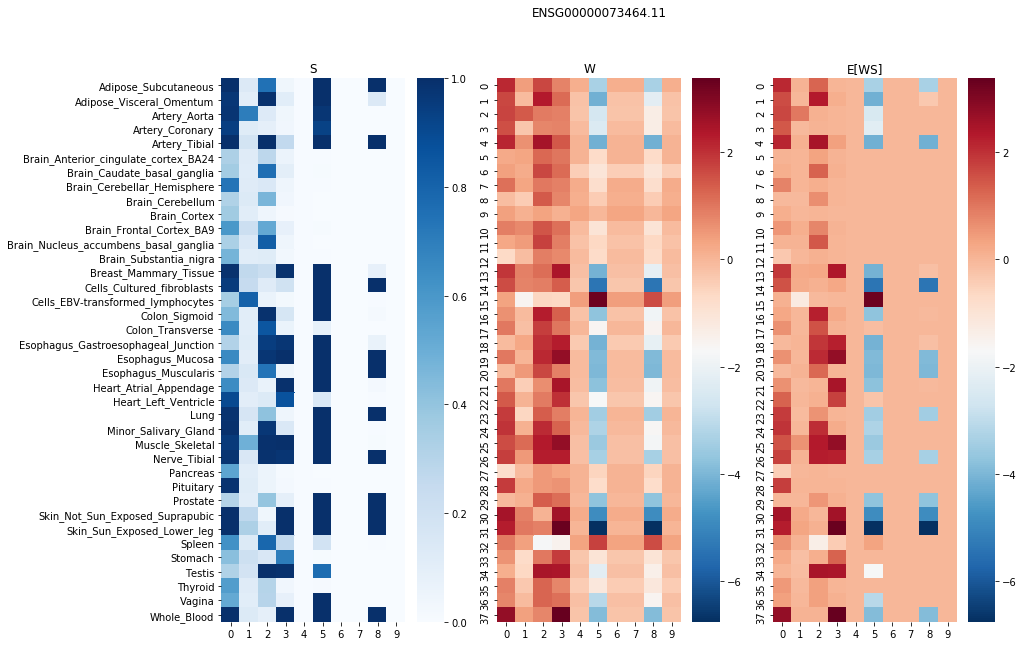

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10))
sns.heatmap(np.exp(m.active), cmap='Blues', ax=ax[0], yticklabels=m.tissues)
sns.heatmap(m.weights, cmap='RdBu_r', ax=ax[1])
sns.heatmap(np.exp(m.active) * m.weights, cmap='RdBu_r', ax=ax[2])
ax[0].set_title('S')
ax[1].set_title('W')
ax[2].set_title('E[WS]')
plt.suptitle(gene)
plt.show()

In [117]:
W = m.weights * np.exp(m.active)
pred = W @ (X @ m.pi).T

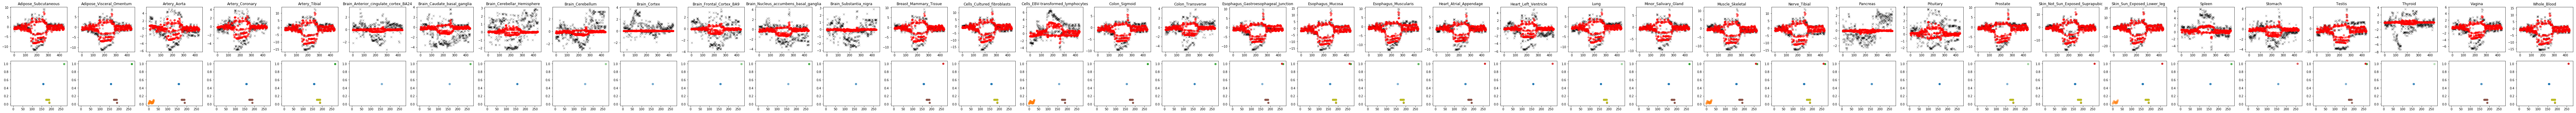

In [128]:
fig, ax = plt.subplots(2, m.T, figsize=(m.T*4, 6))
for t in range(m.T):
    ax[0, t].scatter(np.arange(m.N), Y[t], c='k', marker='x', alpha=0.3)
    ax[0, t].scatter(np.arange(m.N), pred[t], c='r', marker='o', alpha=0.5)

    tissue_active = np.exp(m.active[t])
    tissue_active[tissue_active < 0.3] = 0
    for k in range(m.K):
        ax[1, t].scatter(np.arange(m.N)[m.pi[:, k] > 0.01], m.pi[:, k][m.pi[:, k] > 0.01], alpha=tissue_active[k])
    
    ax[0, t].set_title(m.tissues[t])

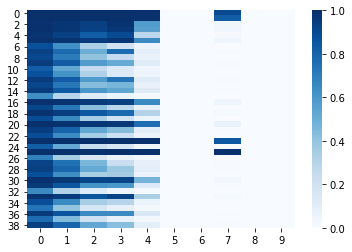

In [52]:
sns.heatmap(np.exp(models[key].active), cmap='Blues')

In [36]:
overview.iloc[10]

K                                20
gene              ENSG00000184293.7
prior_variance                  0.1
run                               0
idx                              10
Name: 10, dtype: object

In [35]:
keys[10]

'geneENSG00000184293.7_sigma20.1_K20_0_model'